# AquaNet Wind

In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd

from loguru import logger

logger.enable("nviro_fetch")

## Setup

In [2]:
from devices import check_and_load_devices
from env import env_global
from readings import (
    export_readings,
    import_readings,
    calculate_time_difference,
)

start_date = env_global("start_date")
end_date = env_global("end_date")
path_data = env_global("path_data")
path_readings = f"{path_data}/readings"
devices = check_and_load_devices()

## 1) Import

In [3]:
device_name = "AquaNet Wind"
device = [device for device in devices if device["device_name"] == device_name][0]
df = import_readings(
    device_name=device["device_name"].replace(" ", "_").lower()
)

2025-06-17 13:38:34.077 | INFO     | readings:import_readings:70 - Importing readings from folder: /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/raw
2025-06-17 13:38:34.078 | INFO     | files:find_file:84 - Found file: aquanet_wind_2025-06-11.csv for device: aquanet_wind
2025-06-17 13:38:34.078 | INFO     | readings:import_readings:74 - Importing readings from file: aquanet_wind_2025-06-11.csv
2025-06-17 13:38:34.090 | INFO     | readings:import_readings:84 - Readings imported successfully from /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/raw/aquanet_wind_2025-06-11.csv


## 2) Common Interval


In [4]:
df["time_diff"] = calculate_time_difference(df["dt"])
df = df[df["time_diff"] >= 5]  # Filter out readings with time difference < 5 minutes

In [5]:
s_diff = df["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head()

time_diff
10      1688
5       1557
6         24
20         3
1199       1
Name: count, dtype: int64

### 2.1) Identify Interval Change


In [6]:
date_change = df[df["time_diff"] == 5]["dt"].max()

In [7]:
df[df["time_diff"] == 10]["dt"].min()

Timestamp('2025-05-24 05:53:00+0000', tz='UTC')

#### 2.2.1) Plot

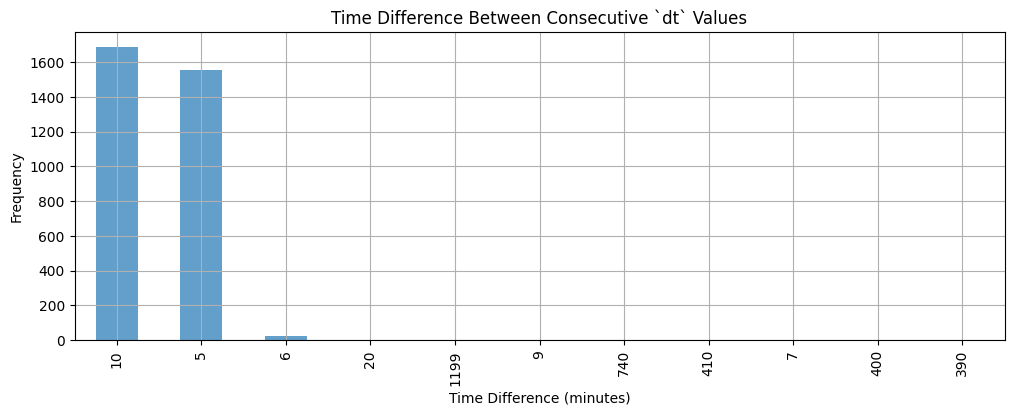

In [8]:
plt.figure(figsize=(12, 4))
s_diff.plot(kind="bar", alpha=0.7)
plt.title("Time Difference Between Consecutive `dt` Values")
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

ANS: 10 min

## 3) Round to common interval

### 3.1) Interval: 5


In [9]:
df1 = df[df["dt"] <= date_change]

s_diff = df1["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

time_diff
5       1557
6         24
10         8
1199       1
9          1
740        1
Name: count, dtype: int64

In [10]:
# Snap all datetimes to the nearest lower 15-minute mark from the hour


freq = "5min"
df1["dt"] = df1["dt"].dt.floor(freq)
# Remove duplicates that may result from flooring
df1 = df1.drop_duplicates(subset="dt", keep="first")

# Optionally, reindex to ensure every 10-minute interval is present
full_range = pd.date_range(df1["dt"].min(), df1["dt"].max(), freq=freq)
df1 = df1.set_index("dt").reindex(full_range)
df1["dt"] = df1.index
# Optionally, forward-fill or interpolate missing values
# df1 = df1.ffill()

/var/folders/lj/7mgr94p96j5bd4lp2lrw84_w0000gn/T/ipykernel_80835/1104927224.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["dt"] = df1["dt"].dt.floor(freq)


In [11]:
df1["dt_diff"] = calculate_time_difference(df1["dt"])
s_diff = df1["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

dt_diff
5    2010
Name: count, dtype: int64

### 3.2) Interval: 10

In [12]:
df2 = df[df["dt"] > date_change]
s_diff = df2["time_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

time_diff
10     1680
20        3
410       1
7         1
400       1
390       1
Name: count, dtype: int64

In [13]:
freq = "10min"
df2["dt"] = df2["dt"].dt.floor(freq)
# Remove duplicates that may result from flooring
df2 = df2.drop_duplicates(subset="dt", keep="first")

# Optionally, reindex to ensure every 10-minute interval is present
full_range = pd.date_range(df2["dt"].min(), df2["dt"].max(), freq=freq)
df2 = df2.set_index("dt").reindex(full_range)
df2["dt"] = df2.index
# Optionally, forward-fill or interpolate missing values
# df2 = df2.ffill()

/var/folders/lj/7mgr94p96j5bd4lp2lrw84_w0000gn/T/ipykernel_80835/612626256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["dt"] = df2["dt"].dt.floor(freq)


In [14]:
df2["dt_diff"] = calculate_time_difference(df2["dt"])
s_diff = df2["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head(len(s_diff))

dt_diff
10    1807
Name: count, dtype: int64

### 3.3) Combine


In [15]:
df_new = pd.concat([df1, df2])
df_new = df_new.sort_values(by="dt")

In [16]:
df_new["time_diff"] = calculate_time_difference(df_new["dt"])

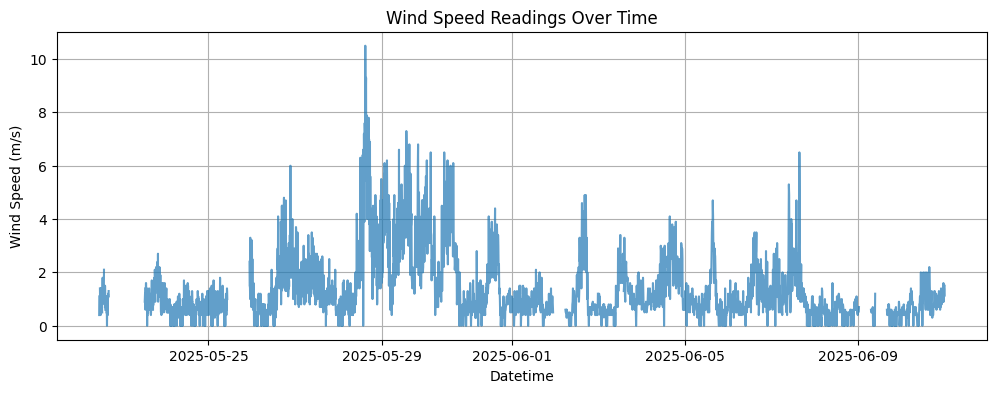

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(df_new['WIND SPEED'], alpha=0.7)
plt.title("Wind Speed Readings Over Time")
plt.xlabel("Datetime")
plt.ylabel("Wind Speed (m/s)")
plt.grid(True)
plt.show()

## 4) Check for any issues

In [18]:
s_diff = df_new["dt_diff"].value_counts().sort_values(ascending=False)
s_diff.head()

dt_diff
5     2010
10    1807
Name: count, dtype: int64

## 5) Set new date as default

In [19]:
df_final = df_new.copy(deep=True)
df_final.reset_index(inplace=True, drop=True)
df_final["datetime"] = df_final["dt"]
df_final.drop(columns=["dt" ,"time_diff", "dt_diff"], inplace=True)

## 6) Export

In [20]:
path_cleaned = os.path.join(path_readings, "cleaned")
end_date = df_final["datetime"].max().strftime("%Y-%m-%d %H:%M:%S")
export_readings(path_cleaned, df_final, device, end_date)